In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

import IPython.display as ipd

import numpy as np
import pandas as pd
import torch

from hparams import create_hparams
from model import SpeakerEncoder
from loss import SpeakerEncoderLoss
from audio import init_stft, mel_spectrogram

import os
import warnings
warnings.filterwarnings("ignore")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/Users/olehmatsuk/opt/anaconda3/envs/taco/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
F = 70

def get_embeddings(model, data, data_dir):
    embeddings = []
    for _, row in data.iterrows():
        mel = mel_spectrogram(os.path.join(data_dir, row['audio']), stft).transpose(0, 1).unsqueeze(0) # 1xSxM
        fragments = mel.unfold(1, F, F // 2).transpose(2, 3)[0]
        embedding = model.inference(fragments, [fragments.size(0)]).squeeze(0)
        embeddings.append(embedding)
    return torch.stack(embeddings).detach()

In [3]:
def load_model(checkpoint_path):
    model = SpeakerEncoder(hparams)
    if checkpoint_path is not None: 
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
    return model

In [4]:
import IPython

def play_audio(audio, data_dir):
    return IPython.display.Audio(os.path.join(data_dir, audio))

In [5]:
def get_speaker_sample(data, speaker):
    return data.loc[data['speaker'] == speaker].sample(1).iloc[0]

In [55]:
from sklearn.decomposition import PCA

def pca_plot(embeddings, labels, genders=None):
    sns.set(rc={'figure.figsize':(12, 12)})
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.numpy())

    for label in np.sort(np.unique(labels)):
        label_index = labels == label
        marker = None if genders is None else ('x' if genders[label] else '.')
        plt.scatter(embeddings_2d[label_index, 0], embeddings_2d[label_index, 1], label=label, marker=marker)
    if genders is not None:
        plt.legend()

In [7]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA

def embedding_stats(embeddings, N, M):
    loss = sum([SpeakerEncoderLoss(N, M, w, -5.0)(embeddings, None).item()
                for w in [5.0, 10.0, 20.0, 40.0]]) / 4
    S = linear_kernel(embeddings)
    S_min, S_max  = np.min(S), np.max(S)

    C = [] # N * MxM
    D = [] # N * M(N-1)xM
    for j in range(N):
        cl = S[j*M:(j+1)*M, j*M:(j+1)*M]
        C.append(S[j*M:(j+1)*M, j*M:(j+1)*M])
        D.append(np.hstack([S[j*M:(j+1)*M, :j*M], S[j*M:(j+1)*M, (j+1)*M:]]))

    C_avg, C_var = np.mean(C), np.var(C)
    D_avg, D_var = np.mean(D), np.var(D)

    Ci = [np.mean(c) for c in C]
    Di = [np.mean(d) for d in D]
    Ci_avg, Ci_var = np.mean(Ci), np.var(Ci)
    Di_avg, Di_var = np.mean(Di), np.var(Di)
    
    print(f'Loss {loss:.2f}')
    print(f'Similarity  max {S_max:.2f} min {S_min:.2f}')
    print(f'Clusterness (+) avg {C_avg:.2f} var {C_var:.2f} | cl avg {Ci_avg:.2f} var {Ci_var:.2f}')
    print(f'Distance    (-) avg {D_avg:.2f} var {D_var:.2f} | cl avg {Di_avg:.2f} var {Di_var:.2f}')
    
    sns.set(rc={'figure.figsize':(8, 3)})
    sns.distplot(np.var(embeddings.data.numpy(), axis=0))
    plt.show()

In [8]:
hparams = create_hparams()
stft = init_stft(hparams)

### Load data

In [38]:
test_common_voice = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/common_voice_test.csv')
test_common_voice.head()

,text,audio,mel,mel_len,speaker
0,Ainsaks võimaluseks liigutada on otse ees olev...,common_voice_et_20836428.mp3,common_voice_et_20836428.npy,581,af3761962fc232e39bd00b879c0cb6efe2aea2f2be4967...
1,Seda suve jääb meenutama kullast teemantidega ...,common_voice_et_20808754.mp3,common_voice_et_20808754.npy,377,53766c5456ef60e9656bf8d8676576cb3644e8aa7eb917...
2,Selleks tuleks ära lugeda istmeread enda ja uk...,common_voice_et_18317620.mp3,common_voice_et_18317620.npy,736,65339a2db81918d9511619601cbbee3d9e6916275c099e...
3,Võistkonna pealiku Michel Nandani sõnul tuleva...,common_voice_et_20803724.mp3,common_voice_et_20803724.npy,612,ca68c58c7ed4883fd69286e66eaadd1d2298b7918ce03f...
4,Ilmselt oskavad nad seda hinnata.,common_voice_et_18313543.mp3,common_voice_et_18313543.npy,288,974410114cfdedc71740c28fc7209922c02b598513c185...


In [10]:
test_konekorpus = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/konekorpus_test.csv')
test_konekorpus.head()

,text,audio,mel,mel_len,speaker
0,Kuid toonane ja praegune Prantsusmaa koondis o...,Katarina/0001_art_864_lause_3.wav,Katarina_0001_art_864_lause_3.npy,247,Katarina
1,"""Põrsas kotis"" festivali raames toimub kuus ko...",Robert/0001_art_860_lause_3.wav,Robert_0001_art_860_lause_3.npy,721,Robert
2,Samas lähedal Kanada piiri ääres möllab metsap...,Kristo/0001_art_367_lause_2.wav,Kristo_0001_art_367_lause_2.npy,907,Kristo
3,Kaks neist majadest rajatakse Jaamamõisa tänav...,Katarina/0001_art_395_lause_11.wav,Katarina_0001_art_395_lause_11.npy,647,Katarina
4,Jaapanile alla jäänud Kolumbia oli teenitult g...,Katarina/0001_art_796_lause_1.wav,Katarina_0001_art_796_lause_1.npy,661,Katarina


In [11]:
test_vctk = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/vctk_test.csv')
test_vctk.head()

,text,audio,mel,mel_len,speaker
0,The body follows the mind.\n,wav48/p240/p240_233.wav,p240_233.npy,258,p240
1,We want to get there.\n,wav48/p244/p244_160.wav,p244_160.npy,240,p244
2,They have known the hard times.,wav48/p292/p292_160.wav,p292_160.npy,236,p292
3,I was just trying to win the golf tournament.\n,wav48/p269/p269_070.wav,p269_070.npy,273,p269
4,My main concern is that public health is not p...,wav48/p279/p279_190.wav,p279_190.npy,298,p279


In [12]:
test_common_voice.shape, test_konekorpus.shape, test_vctk.shape

((2118, 5), (9407, 5), (8817, 5))

In [53]:
common_voice_dir = '/Users/olehmatsuk/Thesis/data/common_voice/et/clips'
konekorpus_dir = '/Users/olehmatsuk/Thesis/data/konekorpus'
vctk_dir = '/Users/olehmatsuk/Thesis/data/vctk'

In [14]:
konekorpus_speakers_genders = {"Meelis_Kompus": 1, 
                               "Tarmo_Maiberg": 1, 
                               "Birgit_Itse": 0, 
                               "Vallo_Kelmsaar": 1, 
                               "Indrek_Kiisler": 1, 
                               "Tõnu_Karjatse": 1, 
                               "Kai_Vare": 0, 
                               "Katarina": 0,
                               "Kristo": 1, 
                               "Robert": 1, 
                               "Stella": 0}

In [28]:
vctk_speaker_info = pd.read_csv(os.path.join(vctk_dir, 'speaker-info.txt'), delimiter='\s*', header=None, skiprows=1)
vctk_speakers_genders = {f'p{row[0]}': 1 if row[2] == 'M' else 0
                         for _, row in vctk_speaker_info.iterrows()}
vctk_speakers_genders['p280'] = 0

### Prepare test data

In [31]:
test_konekorpus_sample = []
for speaker in test_konekorpus['speaker'].unique():
    speaker_sample = test_konekorpus.loc[(test_konekorpus['speaker'] == speaker) & \
                                         (test_konekorpus['mel_len'] >= F)].sample(10)
    test_konekorpus_sample.append(speaker_sample)
test_konekorpus_sample = pd.concat(test_konekorpus_sample)
test_konekorpus_sample.head()

,text,audio,mel,mel_len,speaker
3543,Reedel peetakse Göteborgis kõik kohamängud.,Katarina/0001_art_1137_lause_12.wav,Katarina_0001_art_1137_lause_12.npy,199,Katarina
7171,NAR-i poolt koostatud olemasolevate eluasemete...,Katarina/0001_art_907_lause_3.wav,Katarina_0001_art_907_lause_3.npy,713,Katarina
3051,Homofoobsete väljaütlemiste tõttu sai Hart Osc...,Katarina/0001_art_1243_lause_2.wav,Katarina_0001_art_1243_lause_2.npy,555,Katarina
119,Ootan pikisilmi teilt arvet.,Katarina/0001_art_758_lause_10.wav,Katarina_0001_art_758_lause_10.npy,131,Katarina
5641,Allkirjastatud määrus ei ole keskustele antud ...,Katarina/0001_art_30_lause_14.wav,Katarina_0001_art_30_lause_14.npy,461,Katarina


In [47]:
test_common_voice_sample = []
test_common_voice_speakers = test_common_voice.groupby('speaker'). \
    filter(lambda s: sum(s['mel_len'] >= F) > 10)['speaker'].unique()
for speaker in np.random.choice(test_common_voice_speakers, size=30, replace=False):
    test_common_voice_sample.append(test_common_voice.loc[(test_common_voice['speaker'] == speaker) & \
                                                          (test_common_voice['mel_len'] >= F)].sample(10))
test_common_voice_sample = pd.concat(test_common_voice_sample)
test_common_voice_sample.head()

,text,audio,mel,mel_len,speaker
554,Tema ja mitmed teised pidasid seda langevate r...,common_voice_et_18138797.mp3,common_voice_et_18138797.npy,643,c30d83a0f466767c9cc05bc0e630712019f7a1db1c0193...
466,Tallinna halduskohtu määrusega ja tuuleenergia...,common_voice_et_18138698.mp3,common_voice_et_18138698.npy,836,c30d83a0f466767c9cc05bc0e630712019f7a1db1c0193...
1352,"Tõmbud sa üle kere pingesse, hoiad hinge kinni?",common_voice_et_18138812.mp3,common_voice_et_18138812.npy,402,c30d83a0f466767c9cc05bc0e630712019f7a1db1c0193...
2108,"Kui mehed on kurtnud, et neil pole õieti midag...",common_voice_et_18138722.mp3,common_voice_et_18138722.npy,815,c30d83a0f466767c9cc05bc0e630712019f7a1db1c0193...
1422,Seega oli karjakopli veerjas põndak leppade po...,common_voice_et_18138749.mp3,common_voice_et_18138749.npy,557,c30d83a0f466767c9cc05bc0e630712019f7a1db1c0193...


In [48]:
test_vctk_sample = []
for speaker in np.random.choice(test_vctk['speaker'].unique(), size=15, replace=False):
    test_vctk_sample.append(test_vctk.loc[(test_vctk['speaker'] == speaker) & \
                                          (test_vctk['mel_len'] >= F)].sample(20))
test_vctk_sample = pd.concat(test_vctk_sample)
test_vctk_sample.head()

,text,audio,mel,mel_len,speaker
6253,I can hardly believe it.,wav48/p363/p363_249.wav,p363_249.npy,206,p363
5888,He was very grateful for his health.,wav48/p363/p363_050.wav,p363_050.npy,291,p363
2395,She had not suffered any physical injury.,wav48/p363/p363_367.wav,p363_367.npy,284,p363
1079,We are in shock.,wav48/p363/p363_384.wav,p363_384.npy,203,p363
3037,His film is not.,wav48/p363/p363_043.wav,p363_043.npy,199,p363


In [49]:
test_konekorpus_sample.shape, test_common_voice_sample.shape, test_vctk_sample.shape

((110, 5), (300, 5), (300, 5))

In [19]:
def run_test_konekorpus(model):
    embeddings_konekorpus = get_embeddings(model, test_konekorpus_sample, konekorpus_dir)
    embedding_stats(embeddings_konekorpus, 11, 10)
    pca_plot(embeddings_konekorpus, test_konekorpus_sample['speaker'], konekorpus_speakers_genders)
    plt.show()

In [20]:
def run_test_vctk(model):
    embeddings_vctk = get_embeddings(model, test_vctk_sample, vctk_dir)
    embedding_stats(embeddings_vctk, 15, 20)
    pca_plot(embeddings_vctk, test_vctk_sample['speaker'], vctk_speakers_genders)
    plt.show()

In [50]:
def run_test_common_voice(model):
    embeddings_common_voice = get_embeddings(model, test_common_voice_sample, common_voice_dir)
    embedding_stats(embeddings_common_voice, 20, 15)
    pca_plot(embeddings_common_voice, test_common_voice_sample['speaker'])
    plt.show()

### Load models

In [27]:
sample = get_speaker_sample(test_vctk, 'p280')
play_audio(sample['audio'], vctk_dir)

In [22]:
sample = get_speaker_sample(test_konekorpus, 'Indrek_Kiisler')
play_audio(sample['audio'], konekorpus_dir)

In [23]:
models = {
    'konekorpus 80': '/Users/olehmatsuk/Thesis/runs/speaker_k_Jul04_23_08_52/checkpoint_80000',
    'common_voice 80':  '/Users/olehmatsuk/Thesis/runs/speaker_c_Jul04_23_05_50/checkpoint_80000',
    'common_voice 140': '/Users/olehmatsuk/Thesis/runs/speaker_c_Jul04_23_05_50/checkpoint_140000',
    'common_voice 196': '/Users/olehmatsuk/Thesis/runs/speaker_c_Jul04_23_05_50/checkpoint_196000',
    'common_voice + konekorpus 80':  '/Users/olehmatsuk/Thesis/runs/speaker_ck_Jul04_23_23_32/checkpoint_80000',
    'common_voice + konekorpus 140': '/Users/olehmatsuk/Thesis/runs/speaker_ck_Jul04_23_23_32/checkpoint_140000',
    'common_voice + konekorpus 180': '/Users/olehmatsuk/Thesis/runs/speaker_ck_Jul04_23_23_32/checkpoint_180000',
    'vctk 80':  '/Users/olehmatsuk/Thesis/runs/speaker_v_Jul04_23_05_50/checkpoint_80000',
    'vctk 140': '/Users/olehmatsuk/Thesis/runs/speaker_v_Jul04_23_05_50/checkpoint_140000',
    'vctk 216': '/Users/olehmatsuk/Thesis/runs/speaker_v_Jul04_23_05_50/checkpoint_216000',
}

#### Konekorpus Test Data

konekorpus 80
Loss 2.48
Similarity  max 1.00 min -0.99
Clusterness (+) avg 1.00 var 0.00 | cl avg 1.00 var 0.00
Distance    (-) avg -0.09 var 0.12 | cl avg -0.09 var 0.00


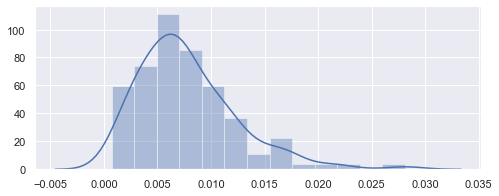

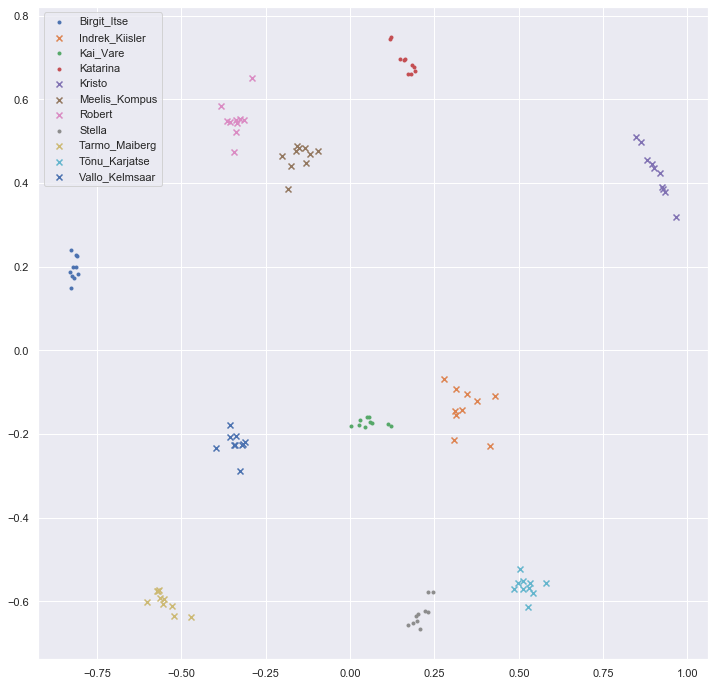

common_voice 80
Loss 51.76
Similarity  max 1.00 min -0.38
Clusterness (+) avg 0.89 var 0.01 | cl avg 0.89 var 0.00
Distance    (-) avg 0.33 var 0.09 | cl avg 0.33 var 0.01


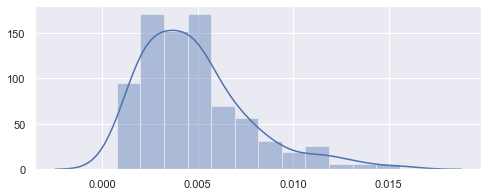

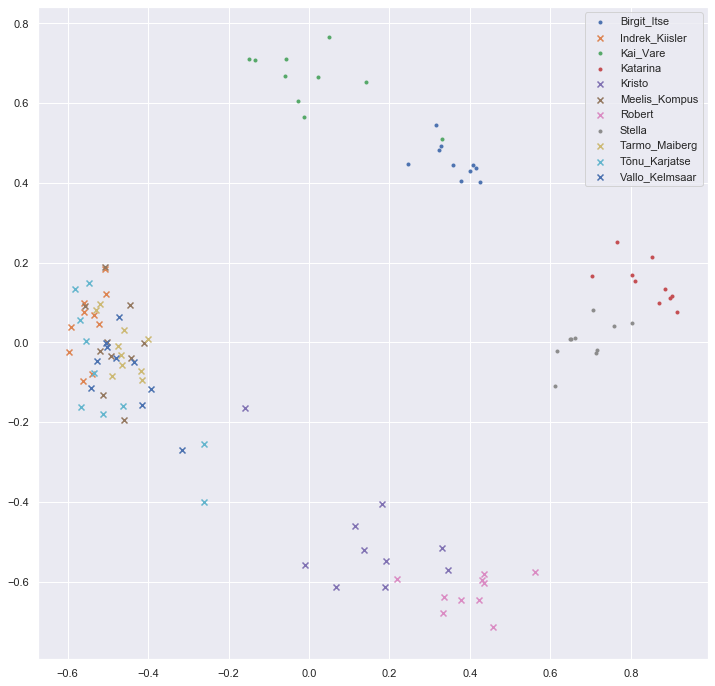

common_voice 140
Loss 33.96
Similarity  max 1.00 min -0.57
Clusterness (+) avg 0.80 var 0.02 | cl avg 0.80 var 0.00
Distance    (-) avg 0.18 var 0.08 | cl avg 0.18 var 0.01


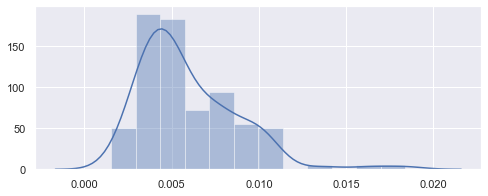

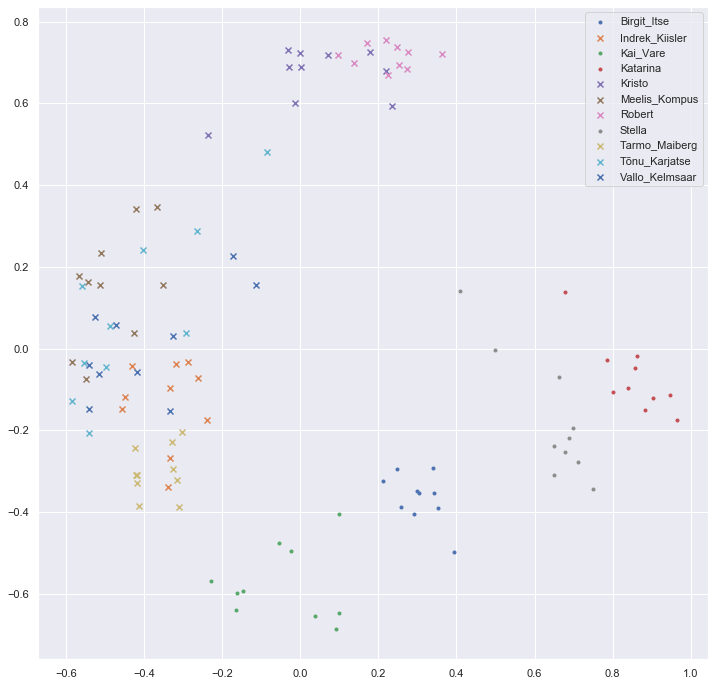

common_voice 196
Loss 38.78
Similarity  max 1.00 min -0.40
Clusterness (+) avg 0.81 var 0.02 | cl avg 0.81 var 0.00
Distance    (-) avg 0.25 var 0.07 | cl avg 0.25 var 0.01


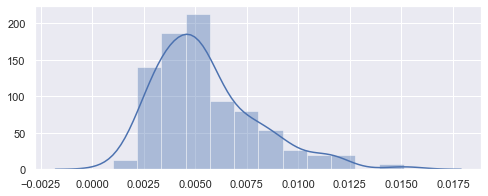

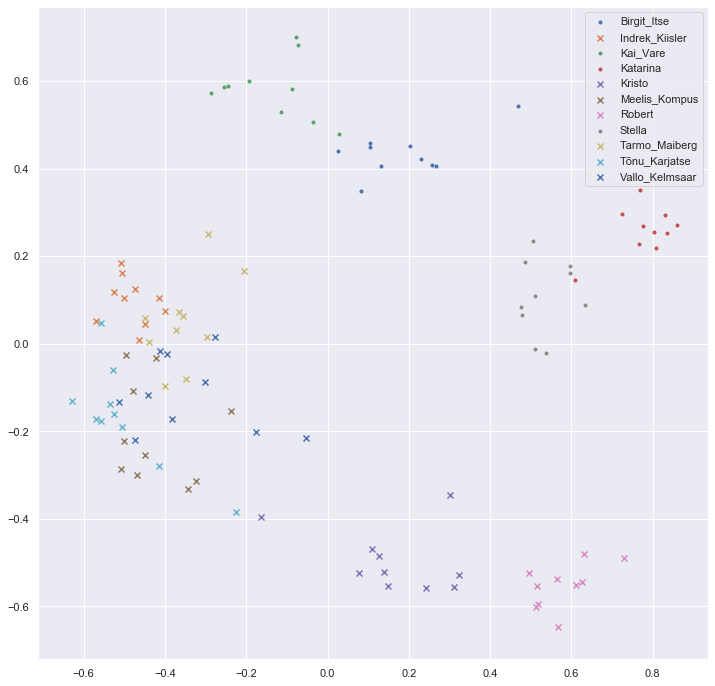

common_voice + konekorpus 80
Loss 9.12
Similarity  max 1.00 min -0.45
Clusterness (+) avg 0.97 var 0.00 | cl avg 0.97 var 0.00
Distance    (-) avg 0.23 var 0.04 | cl avg 0.23 var 0.00


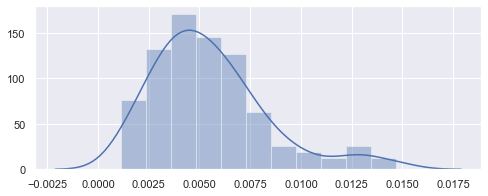

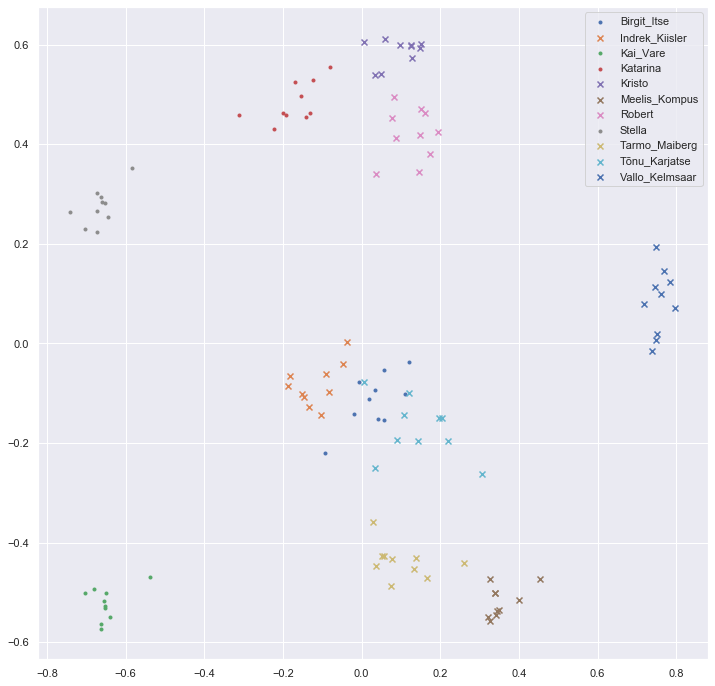

common_voice + konekorpus 140
Loss 5.90
Similarity  max 1.00 min -0.35
Clusterness (+) avg 0.97 var 0.00 | cl avg 0.97 var 0.00
Distance    (-) avg 0.16 var 0.03 | cl avg 0.16 var 0.00


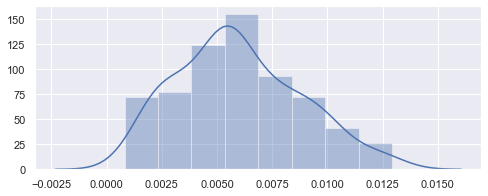

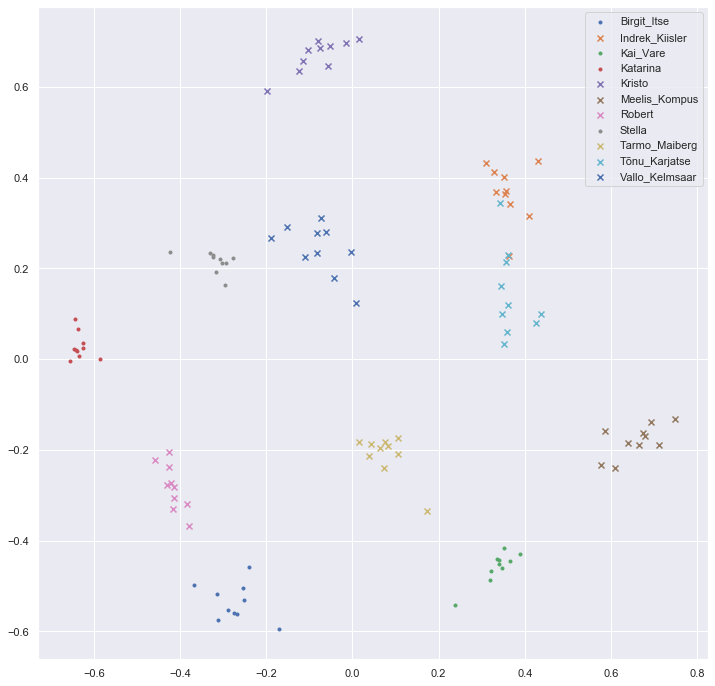

common_voice + konekorpus 180
Loss 5.72
Similarity  max 1.00 min -0.29
Clusterness (+) avg 0.97 var 0.00 | cl avg 0.97 var 0.00
Distance    (-) avg 0.17 var 0.02 | cl avg 0.17 var 0.00


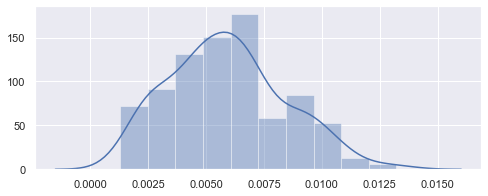

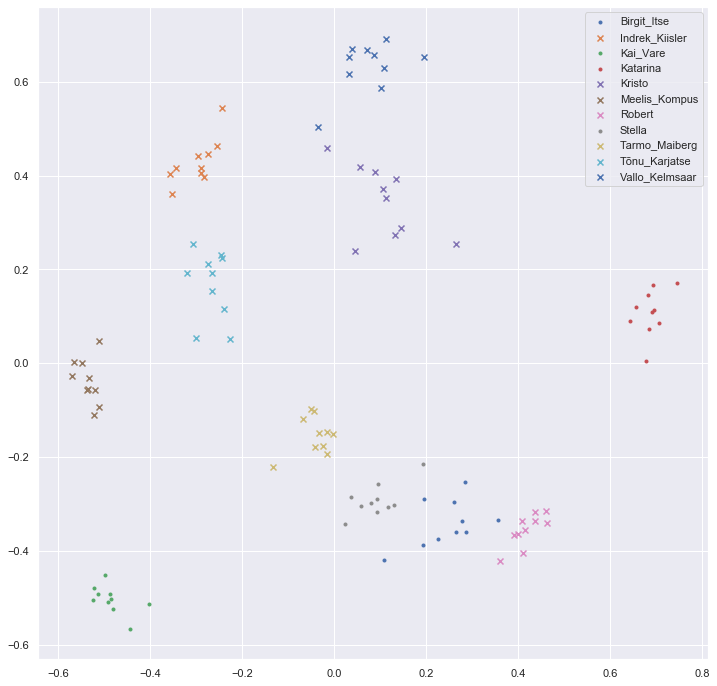

vctk 80
Loss 67.33
Similarity  max 1.00 min -0.48
Clusterness (+) avg 0.85 var 0.02 | cl avg 0.85 var 0.01
Distance    (-) avg 0.28 var 0.11 | cl avg 0.28 var 0.02


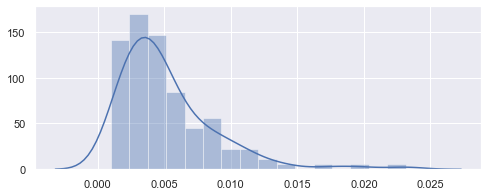

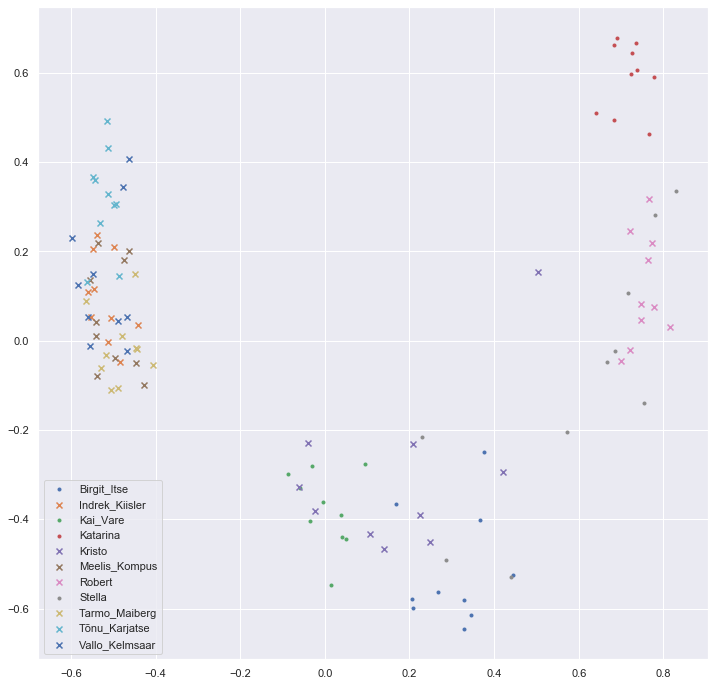

vctk 140
Loss 58.22
Similarity  max 1.00 min -0.52
Clusterness (+) avg 0.85 var 0.02 | cl avg 0.85 var 0.01
Distance    (-) avg 0.23 var 0.11 | cl avg 0.23 var 0.01


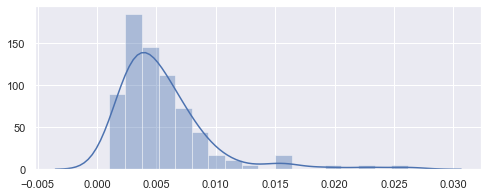

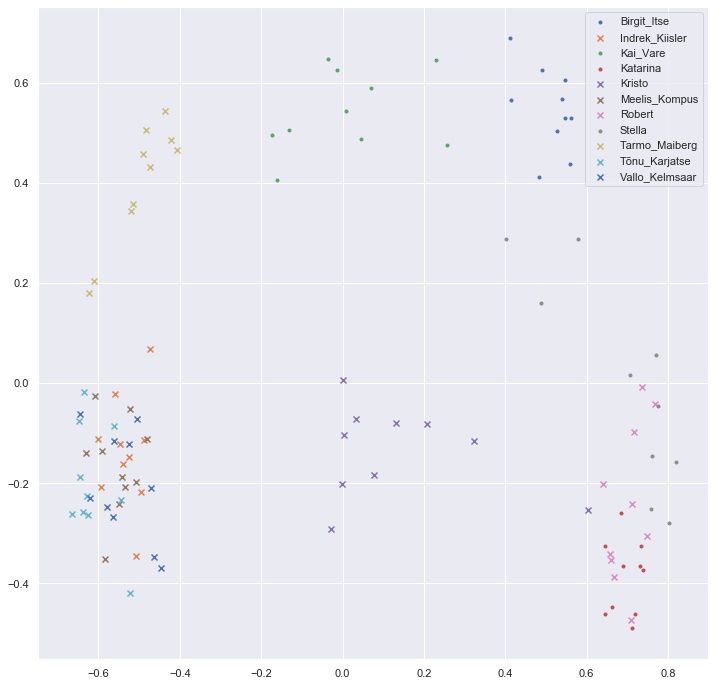

vctk 216
Loss 54.23
Similarity  max 1.00 min -0.56
Clusterness (+) avg 0.80 var 0.02 | cl avg 0.80 var 0.01
Distance    (-) avg 0.21 var 0.09 | cl avg 0.21 var 0.01


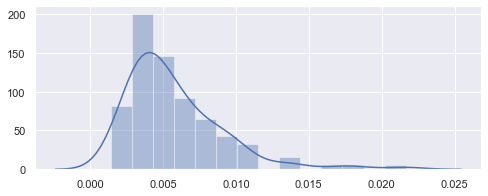

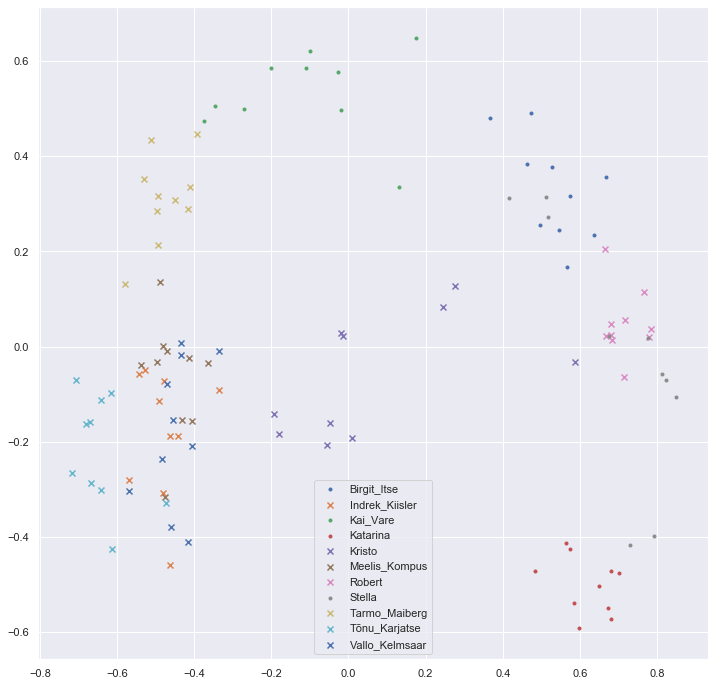

In [24]:
for name, checkpoint in models.items():
    model = load_model(checkpoint)
    print(name)
    run_test_konekorpus(model)

#### VCTK Test Data

konekorpus 80
Loss 423.43
Similarity  max 1.00 min -0.98
Clusterness (+) avg 0.86 var 0.02 | cl avg 0.86 var 0.00
Distance    (-) avg 0.24 var 0.25 | cl avg 0.24 var 0.02


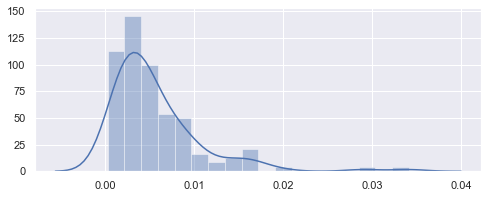

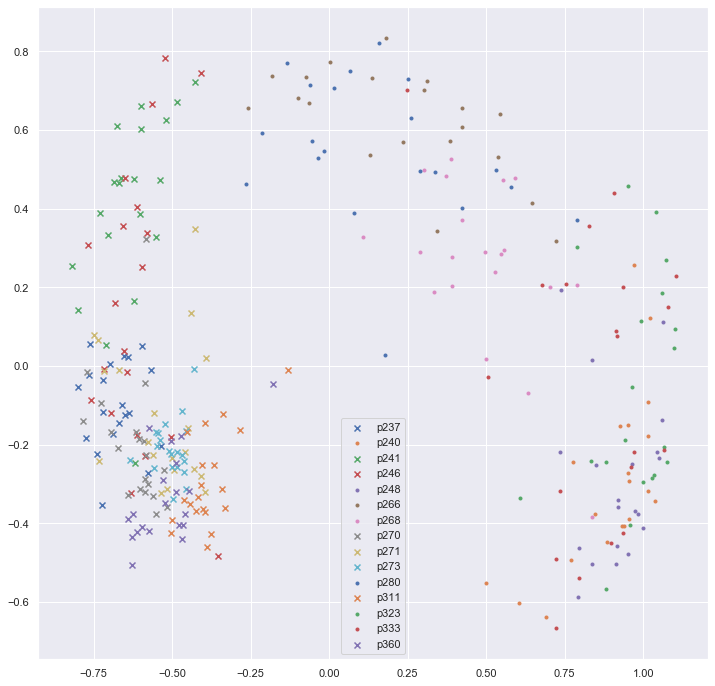

common_voice 80
Loss 336.26
Similarity  max 1.00 min 0.06
Clusterness (+) avg 0.93 var 0.00 | cl avg 0.93 var 0.00
Distance    (-) avg 0.66 var 0.03 | cl avg 0.66 var 0.00


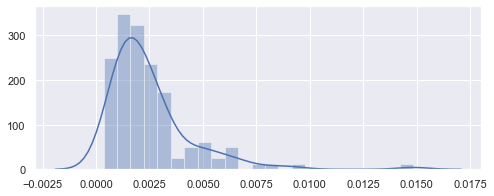

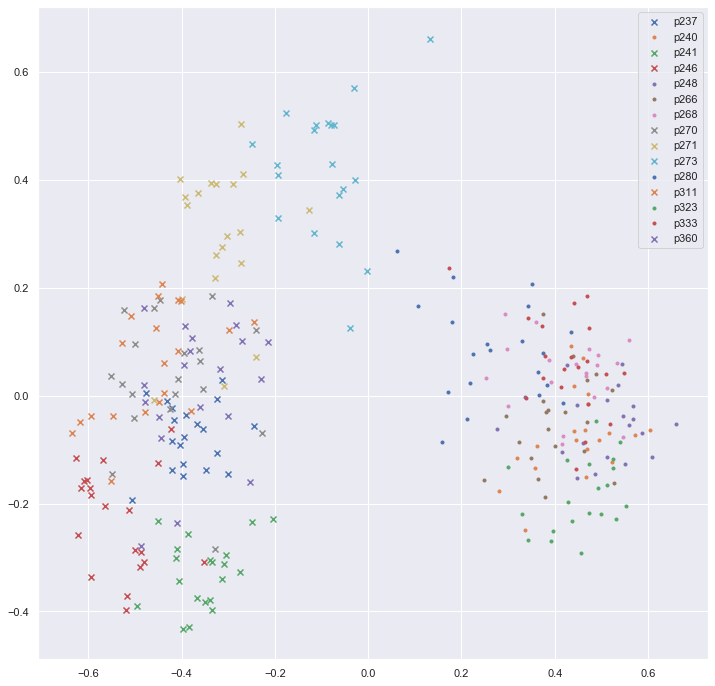

common_voice 140
Loss 293.09
Similarity  max 1.00 min -0.03
Clusterness (+) avg 0.90 var 0.00 | cl avg 0.90 var 0.00
Distance    (-) avg 0.63 var 0.03 | cl avg 0.63 var 0.00


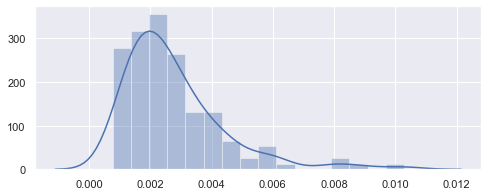

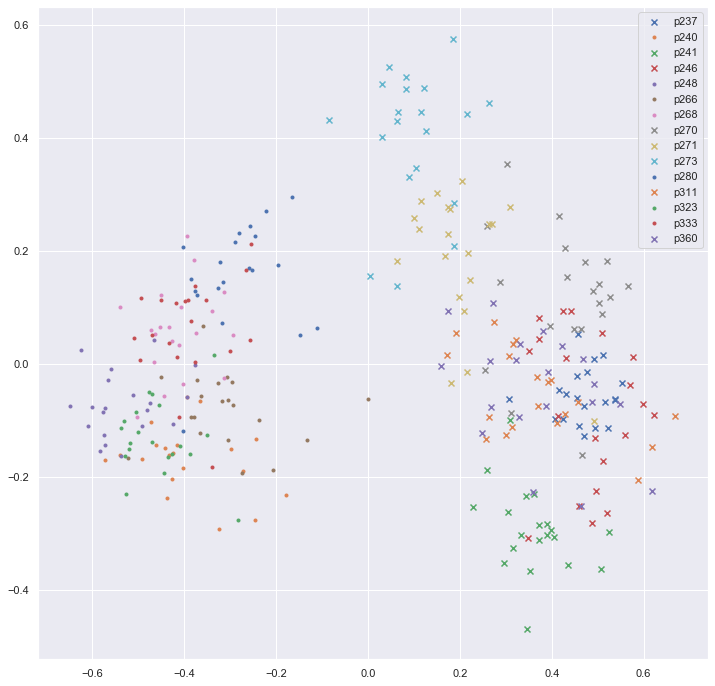

common_voice 196
Loss 240.67
Similarity  max 1.00 min -0.21
Clusterness (+) avg 0.87 var 0.01 | cl avg 0.87 var 0.00
Distance    (-) avg 0.52 var 0.05 | cl avg 0.52 var 0.00


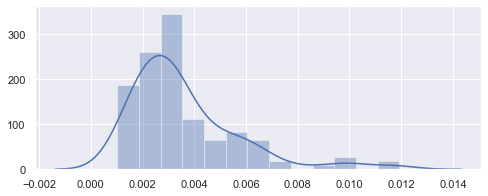

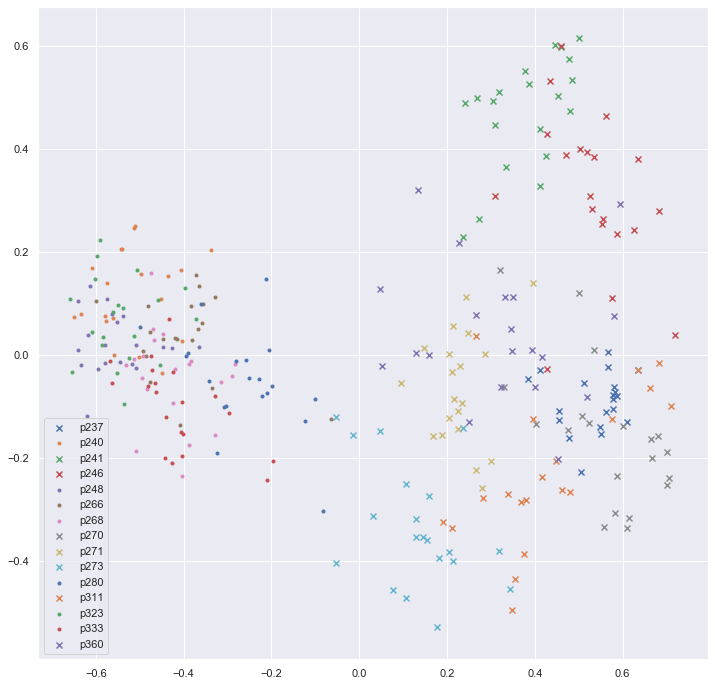

common_voice + konekorpus 80
Loss 298.10
Similarity  max 1.00 min 0.00
Clusterness (+) avg 0.92 var 0.00 | cl avg 0.92 var 0.00
Distance    (-) avg 0.63 var 0.04 | cl avg 0.63 var 0.00


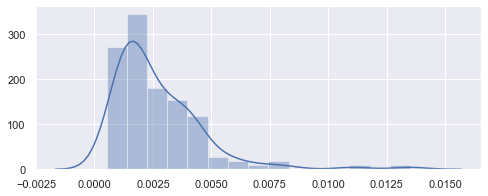

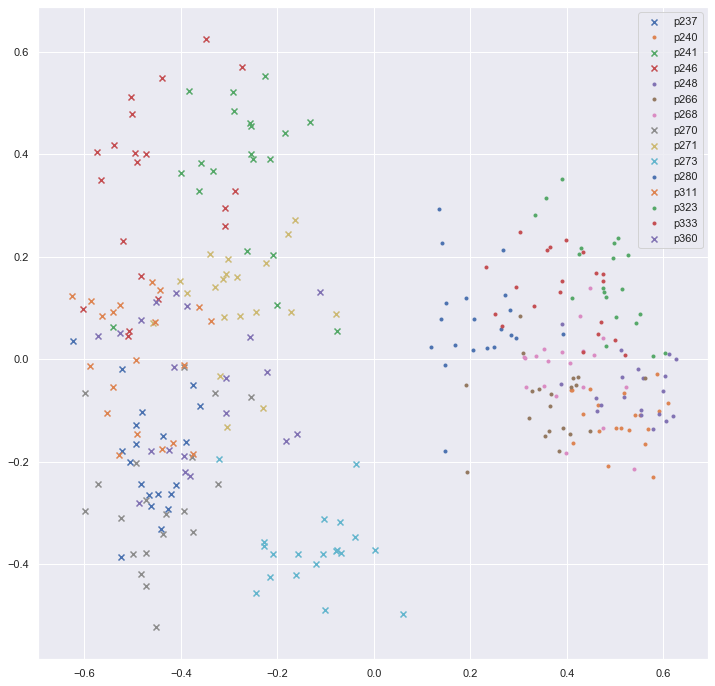

common_voice + konekorpus 140
Loss 266.77
Similarity  max 1.00 min 0.04
Clusterness (+) avg 0.91 var 0.00 | cl avg 0.91 var 0.00
Distance    (-) avg 0.63 var 0.03 | cl avg 0.63 var 0.00


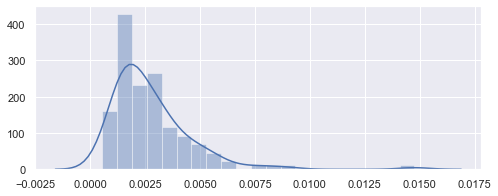

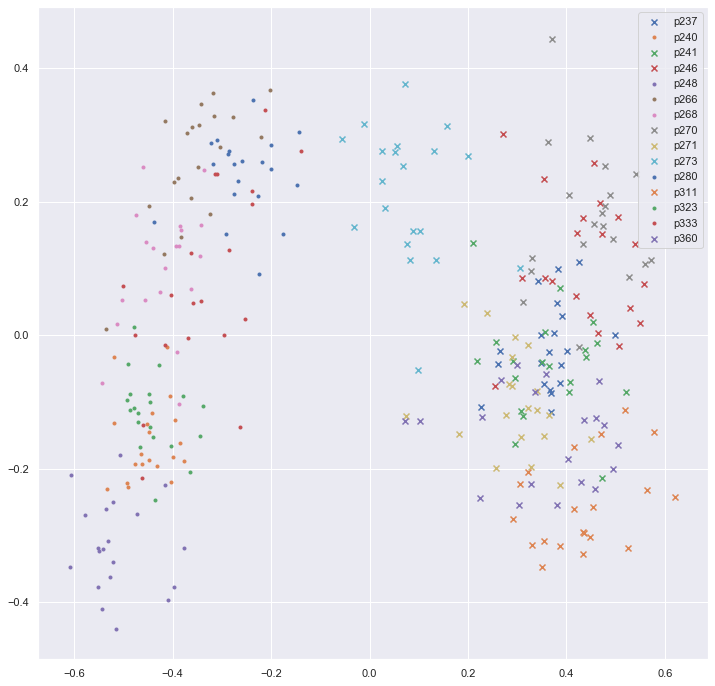

common_voice + konekorpus 180
Loss 267.71
Similarity  max 1.00 min -0.06
Clusterness (+) avg 0.91 var 0.00 | cl avg 0.91 var 0.00
Distance    (-) avg 0.60 var 0.03 | cl avg 0.60 var 0.00


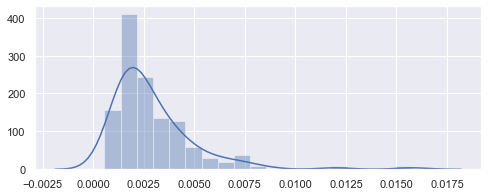

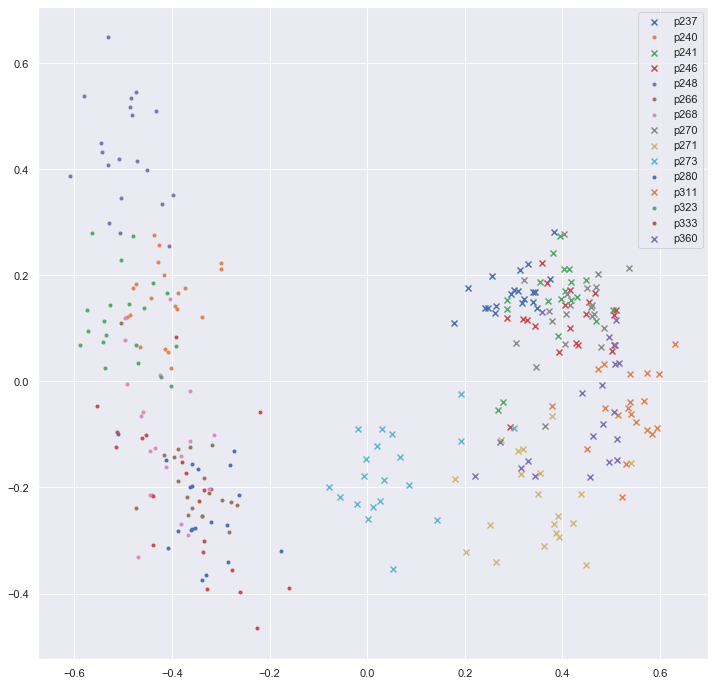

vctk 80
Loss 28.48
Similarity  max 1.00 min -0.79
Clusterness (+) avg 0.91 var 0.01 | cl avg 0.91 var 0.00
Distance    (-) avg 0.06 var 0.07 | cl avg 0.06 var 0.00


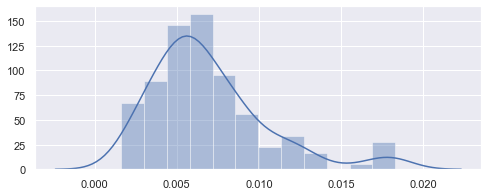

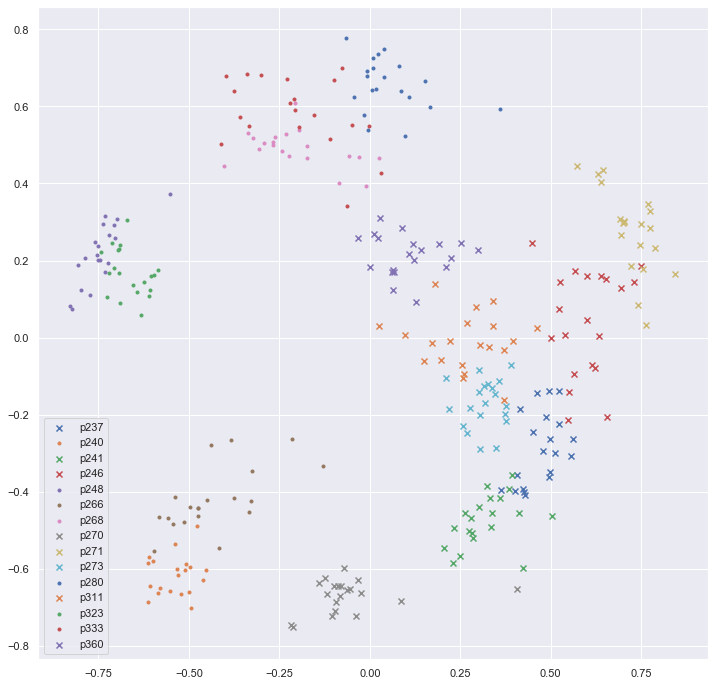

vctk 140
Loss 26.11
Similarity  max 1.00 min -0.70
Clusterness (+) avg 0.92 var 0.00 | cl avg 0.92 var 0.00
Distance    (-) avg 0.09 var 0.05 | cl avg 0.09 var 0.00


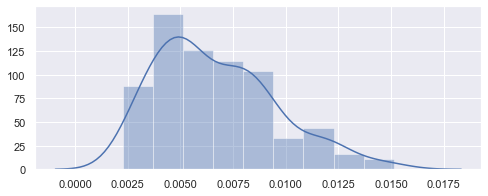

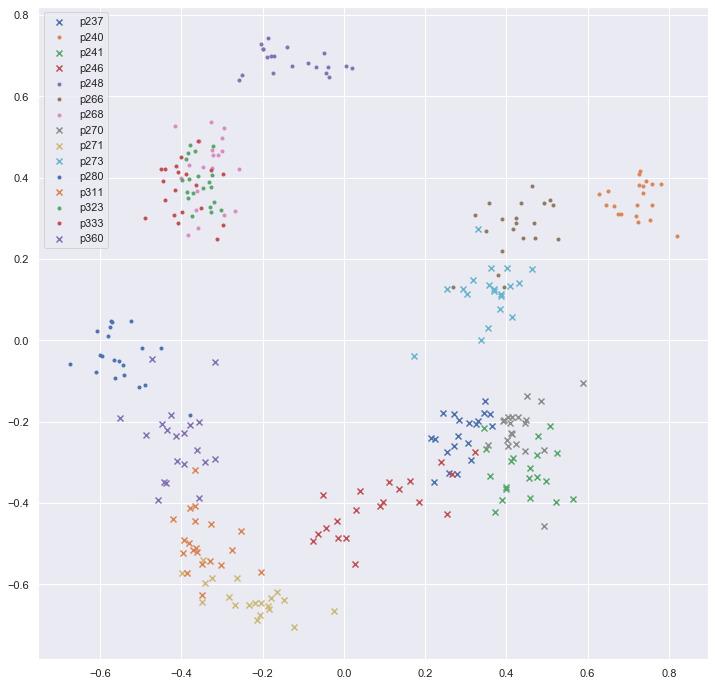

vctk 216
Loss 18.02
Similarity  max 1.00 min -0.50
Clusterness (+) avg 0.92 var 0.00 | cl avg 0.92 var 0.00
Distance    (-) avg 0.05 var 0.04 | cl avg 0.05 var 0.00


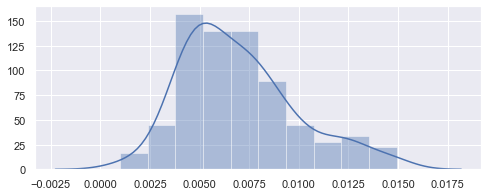

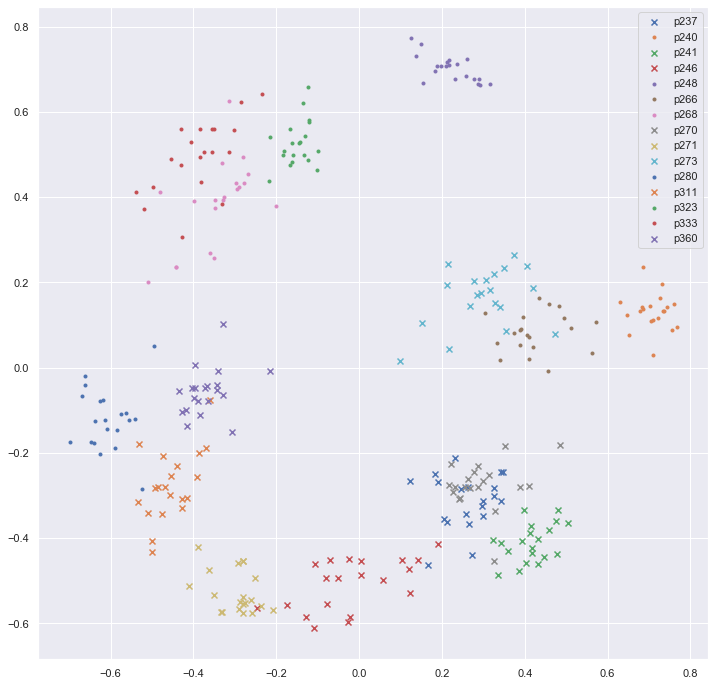

In [29]:
for name, checkpoint in models.items():
    model = load_model(checkpoint)
    print(name)
    run_test_vctk(model)

#### Common Voice Test data

konekorpus 80
Loss 1322.91
Similarity  max 1.00 min -0.99
Clusterness (+) avg 0.56 var 0.23 | cl avg 0.56 var 0.04
Distance    (-) avg 0.22 var 0.22 | cl avg 0.22 var 0.02


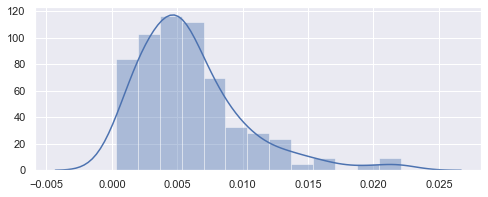

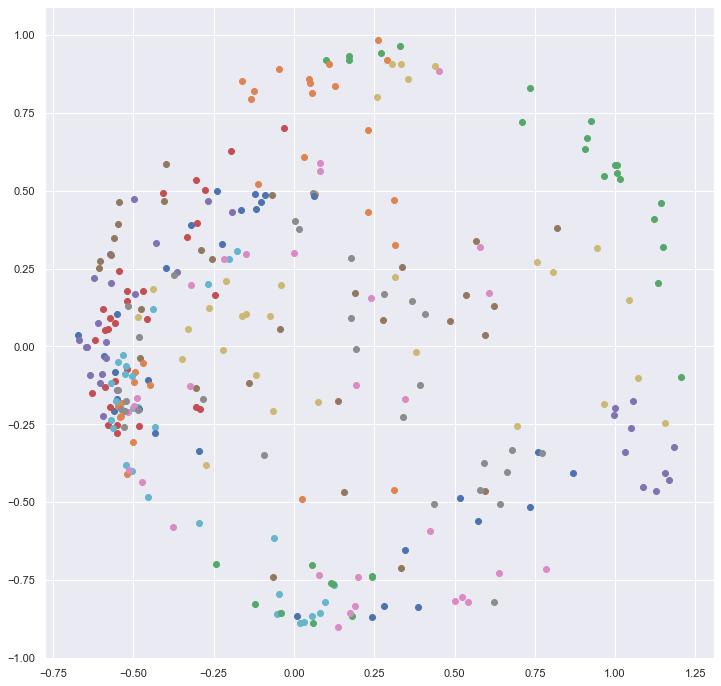

common_voice 80
Loss 605.34
Similarity  max 1.00 min -0.83
Clusterness (+) avg 0.50 var 0.26 | cl avg 0.50 var 0.01
Distance    (-) avg 0.04 var 0.08 | cl avg 0.04 var 0.00


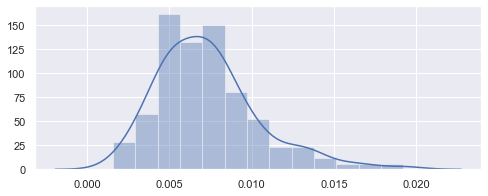

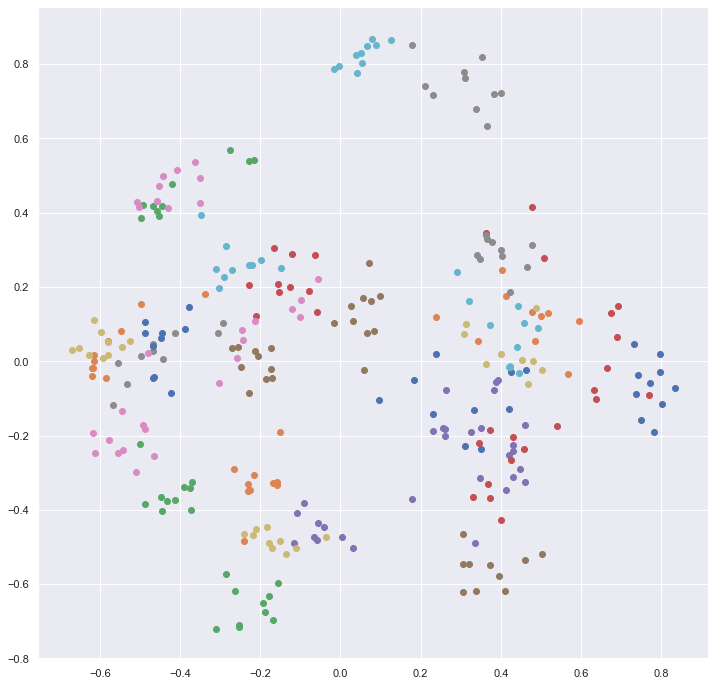

common_voice 140
Loss 335.21
Similarity  max 1.00 min -0.63
Clusterness (+) avg 0.53 var 0.21 | cl avg 0.53 var 0.00
Distance    (-) avg 0.03 var 0.05 | cl avg 0.03 var 0.00


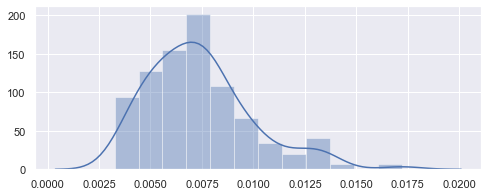

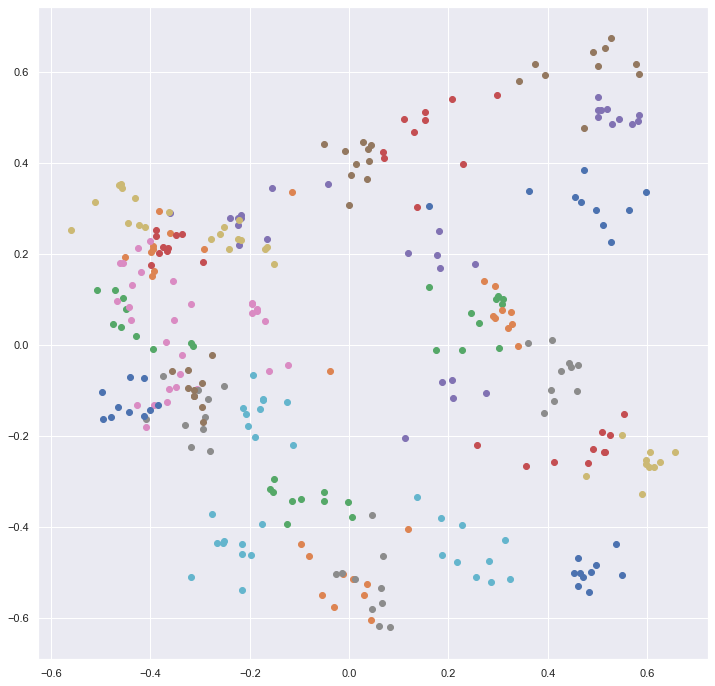

common_voice 196
Loss 331.86
Similarity  max 1.00 min -0.57
Clusterness (+) avg 0.55 var 0.19 | cl avg 0.55 var 0.00
Distance    (-) avg 0.05 var 0.05 | cl avg 0.05 var 0.00


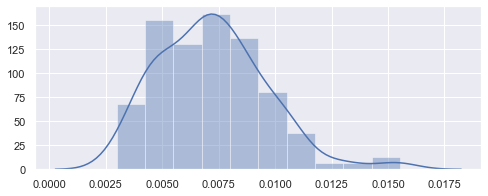

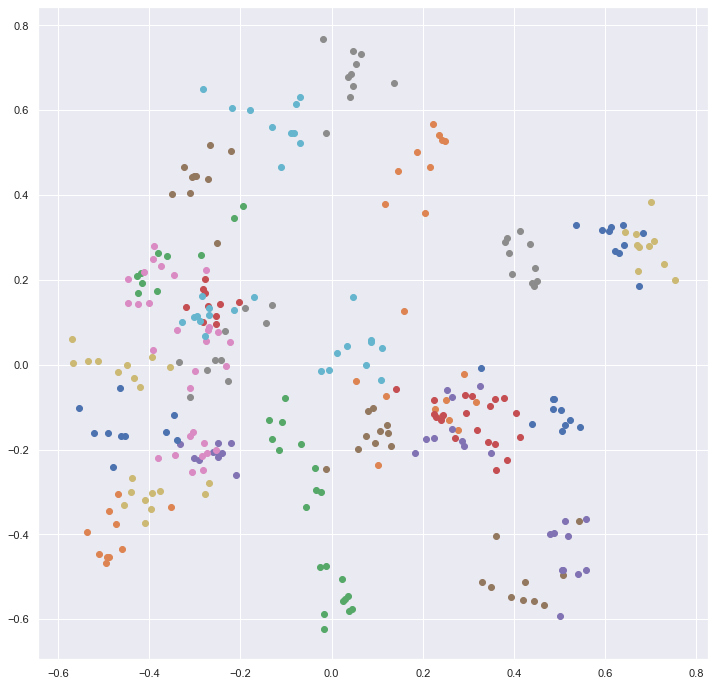

common_voice + konekorpus 80
Loss 528.49
Similarity  max 1.00 min -0.78
Clusterness (+) avg 0.55 var 0.20 | cl avg 0.55 var 0.01
Distance    (-) avg 0.09 var 0.08 | cl avg 0.09 var 0.00


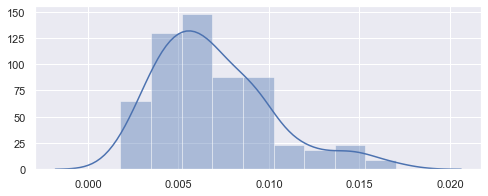

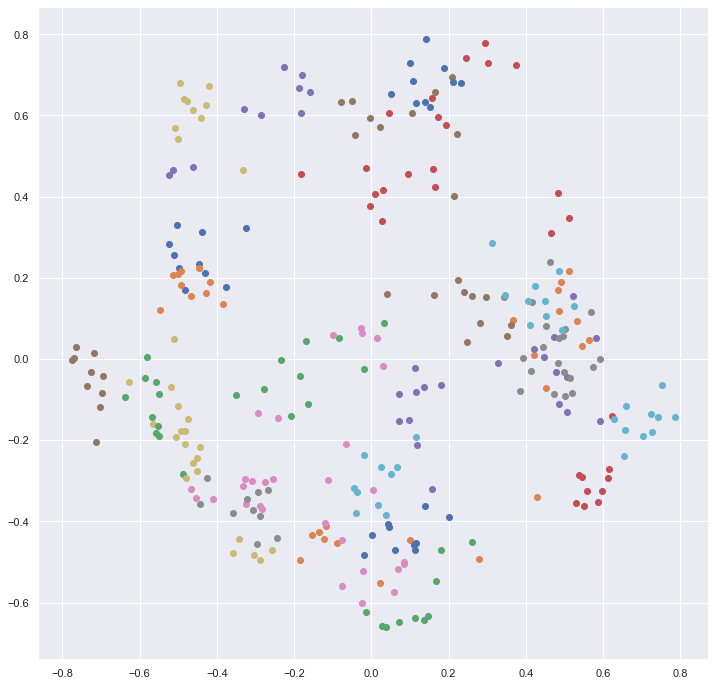

common_voice + konekorpus 140
Loss 421.29
Similarity  max 1.00 min -0.65
Clusterness (+) avg 0.54 var 0.20 | cl avg 0.54 var 0.01
Distance    (-) avg 0.05 var 0.06 | cl avg 0.05 var 0.00


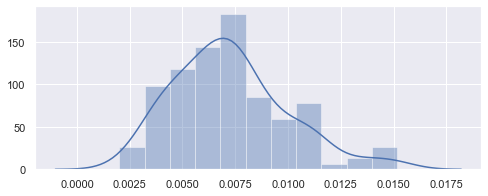

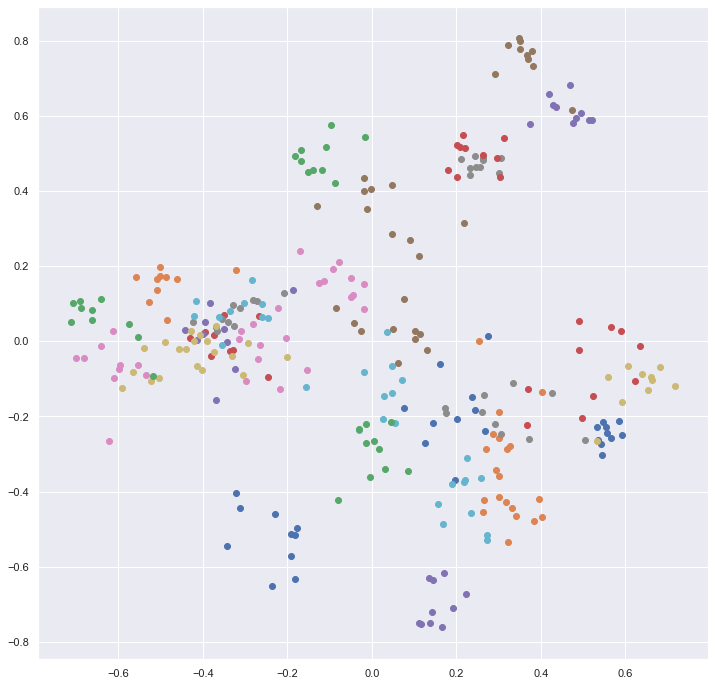

common_voice + konekorpus 180
Loss 357.36
Similarity  max 1.00 min -0.63
Clusterness (+) avg 0.55 var 0.19 | cl avg 0.55 var 0.01
Distance    (-) avg 0.05 var 0.05 | cl avg 0.05 var 0.00


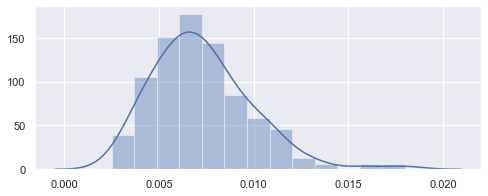

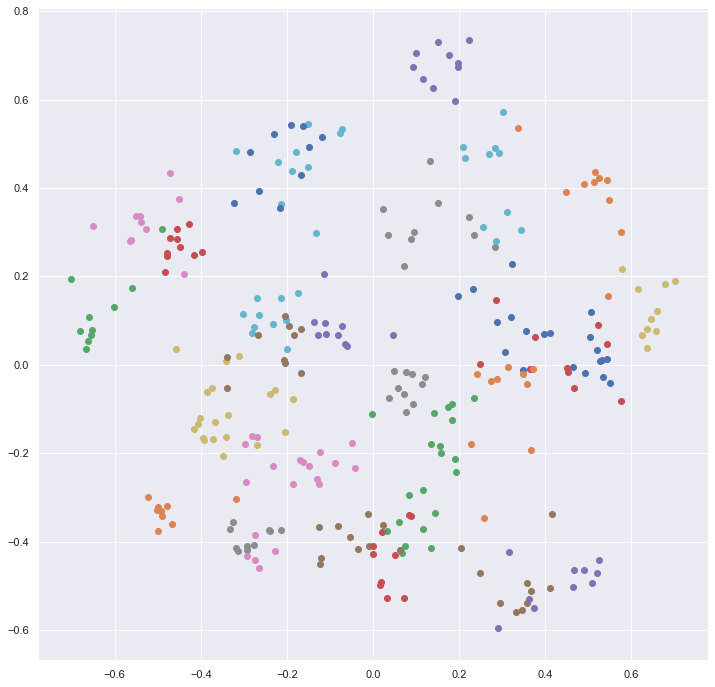

vctk 80
Loss 655.29
Similarity  max 1.00 min -0.39
Clusterness (+) avg 0.72 var 0.07 | cl avg 0.72 var 0.01
Distance    (-) avg 0.54 var 0.06 | cl avg 0.54 var 0.01


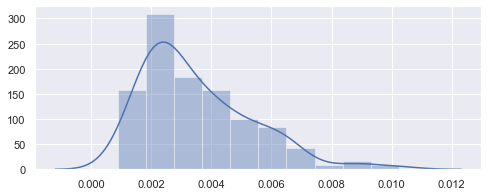

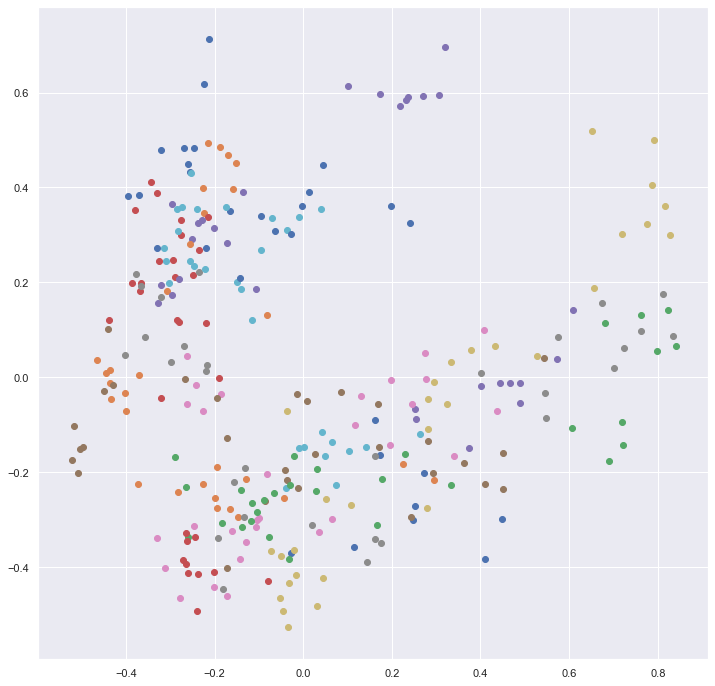

vctk 140
Loss 658.42
Similarity  max 1.00 min -0.38
Clusterness (+) avg 0.67 var 0.08 | cl avg 0.67 var 0.02
Distance    (-) avg 0.47 var 0.05 | cl avg 0.47 var 0.00


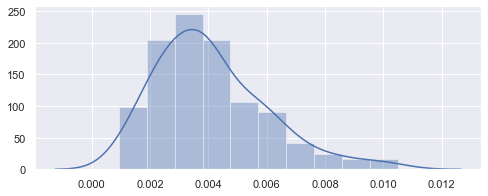

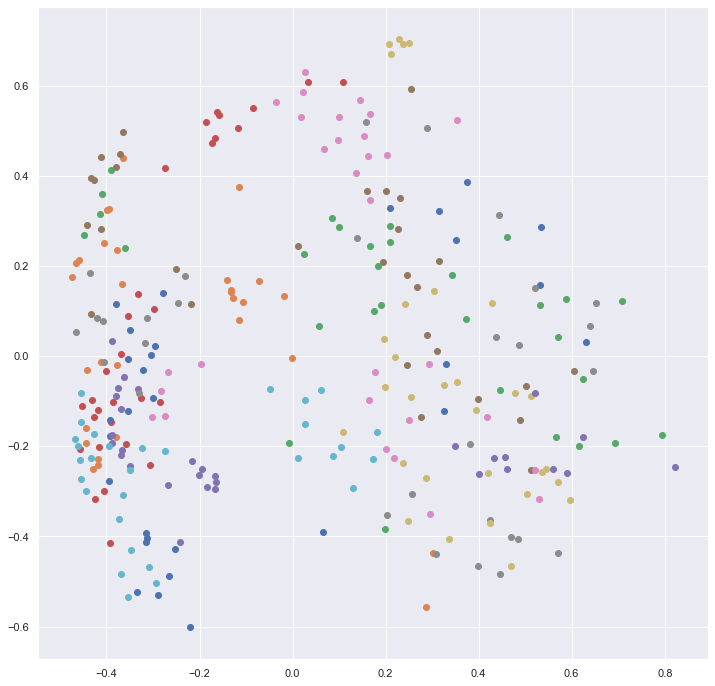

vctk 216
Loss 631.06
Similarity  max 1.00 min -0.39
Clusterness (+) avg 0.68 var 0.07 | cl avg 0.68 var 0.01
Distance    (-) avg 0.47 var 0.05 | cl avg 0.47 var 0.00


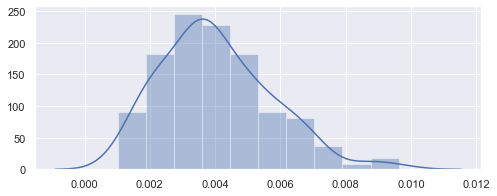

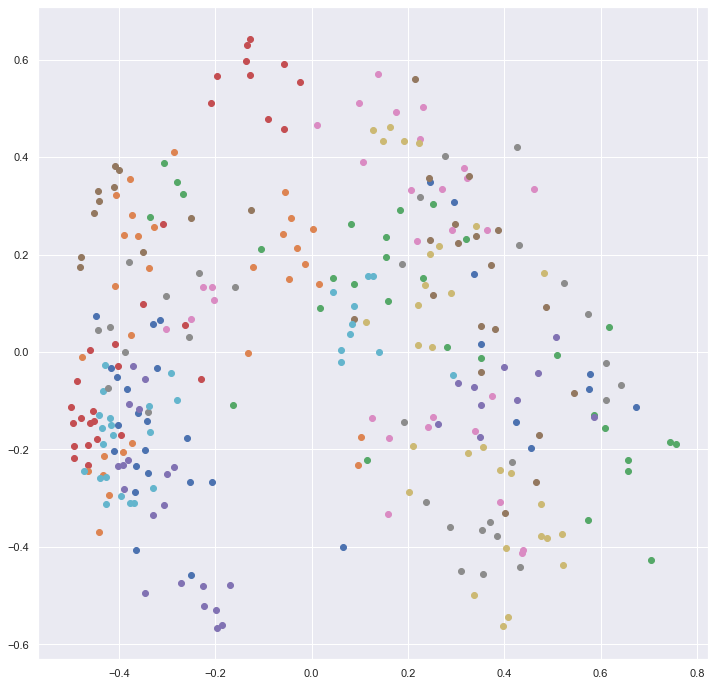

In [56]:
for name, checkpoint in models.items():
    model = load_model(checkpoint)
    print(name)
    run_test_common_voice(model)